<a href="https://colab.research.google.com/github/park-geun-hyeong/Computer_Vision/blob/main/paper/GAN/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms

import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
from tqdm import tqdm_notebook

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [19]:
standardizator = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean = 0.5,
                                                          std = 0.5)

                                        ])

train_data = datasets.MNIST(root = '/content', train=True, transform = standardizator, download=True)
test_data = datasets.MNIST(root = '/content', train=False, transform = standardizator, download=True)  

In [20]:
batch_size=200

train_data_loader = DataLoader(train_data, batch_size, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size, shuffle=True)

In [29]:
for i,t in train_data_loader:
    break

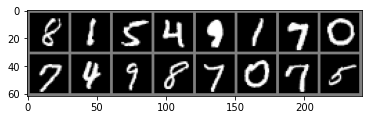

In [62]:
def imshow(img):
    img = (img+1)/2    
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap='gray')
    plt.show()

def imshow_grid(img):
    img = torchvision.utils.make_grid(img.cpu().detach())
    img = (img+1)/2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

example_mini_batch_img, example_mini_batch_label  = next(iter(train_data_loader))
imshow_grid(example_mini_batch_img[0:16,:,:])

In [72]:
d_noise = 100
d_hidden = 256

## Z생성

In [74]:
def sample_z(batch_size=1, d_noise=100):
    return torch.randn(batch_size, d_noise, device=device)

## Generator
- G(z) 생성

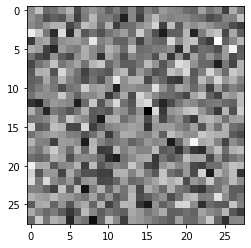

In [82]:
G = nn.Sequential(
    nn.Linear(d_noise, d_hidden),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden, d_hidden),
    nn.ReLU(),
    nn.Dropout(0,1),
    nn.Linear(d_hidden, 28*28),
    nn.Tanh()
).to(device)

z = sample_z()
img_fake = G(z).view(-1, 28, 28)
imshow(img_fake.squeeze().cpu().detach())

## Discriminator

In [88]:
D = nn.Sequential(
    nn.Linear(28*28, d_hidden),
    nn.LeakyReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden, d_hidden),
    nn.LeakyReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden, 1),
    nn.Sigmoid()
).to(device)


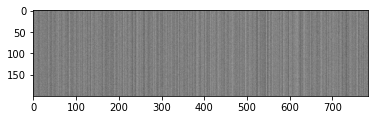

In [90]:
z = sample_z(batch_size)
img_fake = G(z)
imshow_grid(img_fake)

In [94]:
print(G(z).shape)
print(D(G(z)).shape)
print(D(G(z)[0:5]).transpose(0,1))

torch.Size([200, 784])
torch.Size([200, 1])
tensor([[0.4900, 0.4875, 0.4929, 0.4862, 0.4883]], device='cuda:0',
       grad_fn=<TransposeBackward0>)


In [136]:
loss_fn = nn.BCELoss()

def run_epoch(generator, discriminator, _optimizer_g, _optimizer_d):
    generator.train()
    discriminator.train()

    for input, target in train_data_loader:
        input = input.to(device)
        target = target.to(device)

        _optimizer_d.zero_grad()

        p_real = discriminator(input.view(-1, 28*28))
        p_fake = discriminator(generator(sample_z(batch_size, d_noise)))

        loss_real = -1 * torch.log(p_real)
        loss_fake = -1 * torch.log(1. - p_fake)
        loss_d = (loss_real + loss_fake).mean() 

        loss_d.backward()
        _optimizer_d.step()

        _optimizer_g.zero_grad()

        p_fake = discriminator(generator(sample_z(batch_size, d_noise)))

        loss_g = -1 * torch.log(p_fake).mean()

        loss_g.backward()
        _optimizer_g.step()

def evaluate_model(generator, discriminator):
    p_real, p_fake = 0.,0.

    generator.eval()
    discriminator.eval()

    for input, target in test_data_loader:
        input = input.to(device)
        target = target.to(device)

        with torch.autograd.no_grad():
            p_real += (torch.sum(discriminator(input.view(-1, 28*28))).item()) / 10000.
            p_fake += (torch.sum(discriminator(generator(sample_z(batch_size, d_noise)))).item()) / 10000.


    return p_real, p_fake 


In [137]:
def init_params(model):
    for p in model.parameters():
        if (p.dim()>1):
            nn.init.xavier_normal_(p)
        else:
            nn.init.uniform_(p, 0.1, 0.2)

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 10, p_real:0.9621668960571289, p_fake:0.06863813982009885


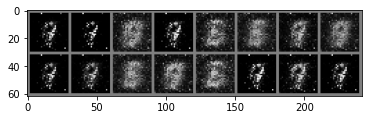

epoch: 20, p_real:0.9405096496582032, p_fake:0.08845974292755128


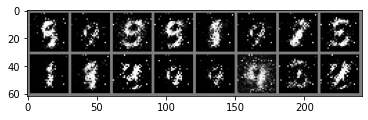

epoch: 30, p_real:0.8558154846191407, p_fake:0.15678584251403813


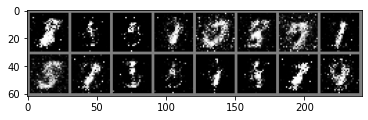

epoch: 40, p_real:0.8215640563964844, p_fake:0.20766242942810056


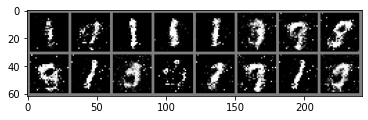

epoch: 50, p_real:0.7797142318725585, p_fake:0.22550559730529787


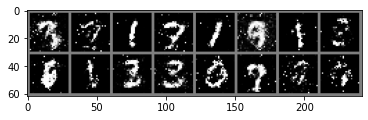

epoch: 60, p_real:0.755779718017578, p_fake:0.2441133445739746


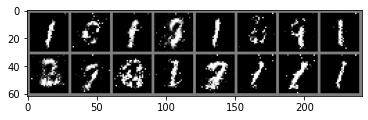

epoch: 70, p_real:0.6885758438110352, p_fake:0.1976796859741211


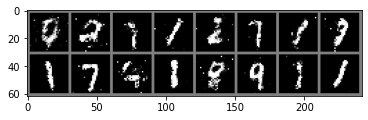

epoch: 80, p_real:0.7387024749755859, p_fake:0.29292589263916013


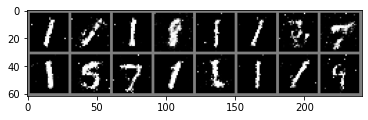

epoch: 90, p_real:0.663455029296875, p_fake:0.2061224700927735


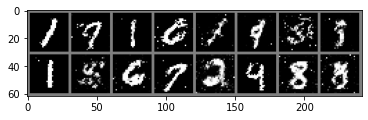

epoch: 100, p_real:0.6952316848754884, p_fake:0.297268575668335


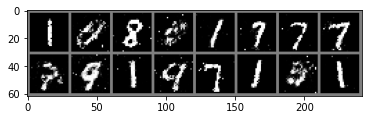

epoch: 110, p_real:0.6649333564758301, p_fake:0.31606527824401864


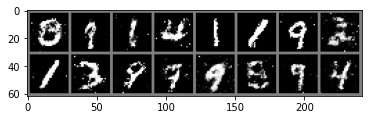

epoch: 120, p_real:0.6401607917785643, p_fake:0.271383918762207


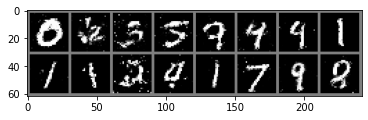

epoch: 130, p_real:0.6947960174560547, p_fake:0.293644817352295


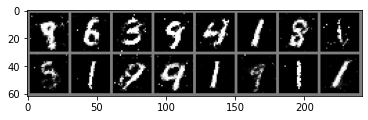

epoch: 140, p_real:0.6249985275268557, p_fake:0.280097353363037


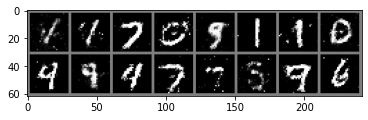

epoch: 150, p_real:0.6223880027770996, p_fake:0.22693041915893558


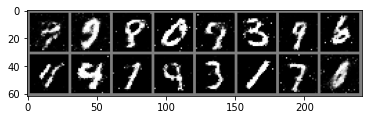

epoch: 160, p_real:0.643170128631592, p_fake:0.2653261333465576


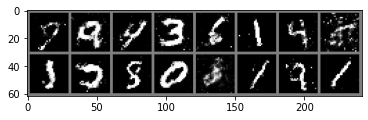

epoch: 170, p_real:0.6483901023864749, p_fake:0.25919814605712893


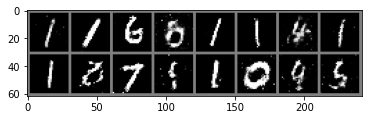

epoch: 180, p_real:0.6492298065185547, p_fake:0.31125212783813466


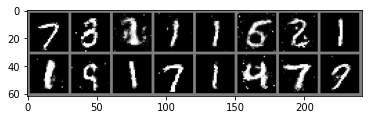

epoch: 190, p_real:0.6430951210021973, p_fake:0.3119391803741455


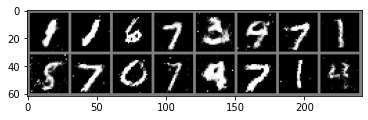

epoch: 200, p_real:0.6044349044799805, p_fake:0.2972419124603273


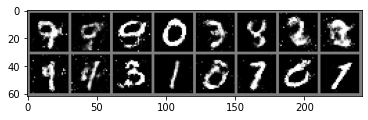

In [138]:
init_params(G)
init_params(D)

optimizer_g = optim.Adam(G.parameters(), lr=0.0002)
optimizer_d = optim.Adam(D.parameters(), lr=0.0002)

p_real_trace=[]
p_fake_trace=[]

for epoch in tqdm_notebook(range(200)):
    run_epoch(G,D, optimizer_g, optimizer_d)
    p_real, p_fake = evaluate_model(G,D)

    p_real_trace.append(p_real)
    p_fake_trace.append(p_fake)

    if ((epoch+1) % 10 == 0):
        print(f"epoch: {epoch+1}, p_real:{p_real}, p_fake:{p_fake}")
        imshow_grid(G(sample_z(16)).view(-1,1,28,28)) 

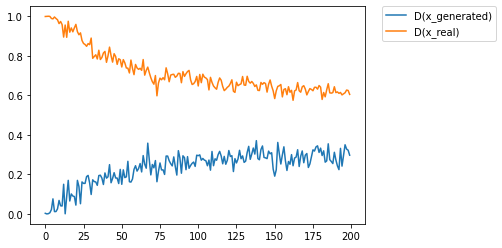

In [142]:
plt.plot(p_fake_trace, label='D(x_generated)')
plt.plot(p_real_trace, label='D(x_real)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()